<a href="https://colab.research.google.com/github/ollihansen90/Mathe-SH-ML/blob/main/Quickdraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickdraw-CNN

https://quickdraw.withgoogle.com/

## Setup

In [ ]:
!wget https://raw.githubusercontent.com/ollihansen90/Mathe-SH-ML/main/quickdraw_cnn_utils.py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import requests, io, sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

--2023-02-21 19:46:35--  https://raw.githubusercontent.com/ollihansen90/Mathe-SH-ML/main/quickdraw_cnn_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6925 (6.8K) [text/plain]
Saving to: ‘quickdraw_cnn_utils.py’

quickdraw_cnn_utils 100%[===================>]   6.76K  --.-KB/s    in 0s      

2023-02-21 19:46:35 (68.1 MB/s) - ‘quickdraw_cnn_utils.py’ saved [6925/6925]



In [ ]:
from quickdraw_cnn_utils import MasterDset, Dset, make_prediction_canvas, predict_func
canvas_size = (280, 280)
if 'google.colab' in sys.modules:
    from google.colab import output
    output.register_callback('predict_func', predict_func)

import numpy as np
import torch
import sys
from PIL import Image
from time import time

canvas_size = (280, 280)
from IPython.core.display import display, HTML

def make_prediction_canvas(canvas_size, prediction_func_name):
        canvas_html = '''
<div>
<p>Drawing canvas:</p>
<canvas id="canvas" width="''' + str(canvas_size[0]) + '''" height="''' + str(canvas_size[1]) + '''" style="border: 5px solid black"></canvas>
<button onclick="predict()">Predict</button>
<button onclick="clear_canvas()">Clear canvas</button>
<p id="predictionfield">Prediction:</p>
</div>
<script type="text/Javascript">
function prediction_callback(data){
    if (data.msg_type === 'execute_result') {
        document.getElementById("predictionfield").innerHTML = "Prediction: " + data.content.data['text/plain']
        /*$('#predictionfield').html("Prediction: " + data.content.data['text/plain'])*/
    } else {
        console.log(data)
    }
}
function predict(){
    var imgData = ctx.getImageData(0, 0, ctx.canvas.width, ctx.canvas.height);
    imgData = Array.prototype.slice.call(imgData.data).filter(function (data, idx) { return idx % 4 == 3; })
    var kernelAPI = undefined
    try {
      //check if defined
      if (IPython) {
        kernelAPI = "IPython"
      }
    } catch(err) {
    }
    try {
      //check if defined
      if (google) {
        kernelAPI = "google"
      }
    } catch(err) {
    }
    if (kernelAPI === "IPython") {
        var command = "''' + prediction_func_name + '''(" + JSON.stringify(imgData) + ")"
        document.getElementById("predictionfield").innerHTML = "Prediction: calculating..."
        /*$('#predictionfield').html("Prediction: calculating...")*/
        var kernel = IPython.notebook.kernel;
        kernel.execute(command, {iopub: {output: prediction_callback}}, {silent: false});
    } else if (kernelAPI === "google") {
        google.colab.kernel.invokeFunction("''' + prediction_func_name + '''", [imgData], {})
        .then(function(result) {
            prediction_callback({msg_type: 'execute_result', content: {data: result.data}})
        })
    } else {
        console.error('no kernel api found to invoke predictions!')
    }
}
canvas = document.getElementById('canvas')
ctx = canvas.getContext("2d")
var clickX = new Array();
var clickY = new Array();
var clickDrag = new Array();
var paint;
function clear_canvas() {    
    clickX = new Array();
    clickY = new Array();
    clickDrag = new Array();
    
    redraw();
    document.getElementById("predictionfield").innerHTML = "Prediction: ";
}
function addClick(x, y, dragging)
{
  clickX.push(x);
  clickY.push(y);
  clickDrag.push(dragging);
}
var canvas = document.getElementById("canvas")
/*$('#canvas').mousedown(*/
canvas.addEventListener('mousedown', function(e){
  var boundingRect = canvas.getBoundingClientRect()
  var mouseX = e.pageX - boundingRect.left;
  var mouseY = e.pageY - boundingRect.top;
  
  paint = true;
  addClick(mouseX, mouseY);
  redraw();
});
/*$('#canvas').mousemove(*/
canvas.addEventListener('mousemove', function(e){
  if(paint){
    var boundingRect = canvas.getBoundingClientRect()
    addClick(e.pageX - boundingRect.left, e.pageY - boundingRect.top, true);
    redraw();
  }
});
/*$('#canvas').mouseup(*/
canvas.addEventListener('mouseup', function(e){
  paint = false;
});
/*$('#canvas').mouseleave(*/
canvas.addEventListener('mouseleave', function(e){
  paint = false;
});
function redraw(){
  ctx.clearRect(0, 0, ctx.canvas.width, ctx.canvas.height); // Clears the canvas
  
  ctx.strokeStyle = '#000000';//"#df4b26";
  ctx.lineJoin = "round";
  ctx.lineWidth = 10;
  for(var i=0; i < clickX.length; i++) {
    ctx.beginPath();
    if(clickDrag[i] && i){
      ctx.moveTo(clickX[i-1], clickY[i-1]);
     }else{
       ctx.moveTo(clickX[i]-1, clickY[i]);
     }
     ctx.lineTo(clickX[i], clickY[i]);
     ctx.closePath();
     ctx.stroke();
  }
}
</script>
'''
        display(HTML(canvas_html)) 

def predict_func(img_data):
    #transform the list into a 2d array
    img_data = np.asarray(img_data, dtype=np.float32).reshape(*canvas_size)
    #transform the numpy array into a torch tensor
    x = torch.tensor(img_data, dtype=torch.float).to(device)
    x /= 255
    #move it to the GPU is possible
    #scale it down from 280x280 to 28x28 pixels using bilinear interpolation
    x = torch.nn.functional.interpolate(x.unsqueeze_(dim=0).unsqueeze_(dim=1), size=(28, 28), mode='bilinear', align_corners=True).squeeze_(dim=1).squeeze_(dim=0)
    #flip dimensions to match dataset
    #x = x.transpose(0, 1)
    #add a batch dimension with batch_size=1
    x.unsqueeze_(dim=0)
    #add a color dimension with color channel count=1
    x.unsqueeze_(dim=1)
    x[x>0.5] = 1
    x[x<=0.5] = 0
    #plt.figure()
    #plt.imshow(x.squeeze().detach().cpu().numpy())
    #plt.show()
    #print(torch.min(x), torch.max(x))
    #switch model to evaluation mode (only necessary for some modules like dropout and batch normalization, but better to always have it rather than forget it when needed)
    model.eval()
    #predict the label for the input
    global out
    with torch.no_grad():#we don't want to store information for gradient computation
        out = model(x)
    #get the most likely label
    #print(F.softmax(out, dim=-1))
    pred_label = out.argmax(1)
    #print(pred_label)
    pred_label = pred_label.item()
    #Image.fromarry(img_data).save("images/"+str(time())+"_"+str(pred_label)+".png")
    #return the predicted class name to the HTML-framework (to be displayed below)
    return DS_test.labelnames[pred_label]

#create the prediction canvas and make it use the prediction function defined above
if 'google.colab' in sys.modules:
    from google.colab import output
    output.register_callback('predict_func', predict_func)

## Datensatz

https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap

In [ ]:
linklist = [
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/butterfly.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/camera.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/duck.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/mouse.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/owl.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pineapple.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sea%20turtle.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sheep.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/snowman.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/swan.npy",
            "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy",
            ]
labelnames = [
            "Schmetterling",
            "Kamera",
            "Becher",
            "Ente",
            "Maus",
            "Eule",
            "Ananas",
            "Schildkröte",
            "Schaf",
            "Schneemann",
            "Sonne",
            "Schwan",
            "Regenschirm",
            ]

DS_train, DS_test = MasterDset(n_imgs=20_000, n_test=1000, linklist=linklist, labelnames=labelnames)
print(len(DS_train), len(DS_test))

tensor([ 1.,  4., 12.,  3., 12.,  2.,  5.,  4.,  4.,  0.,  8.,  3.,  5.,  8.,
         6.,  5.])


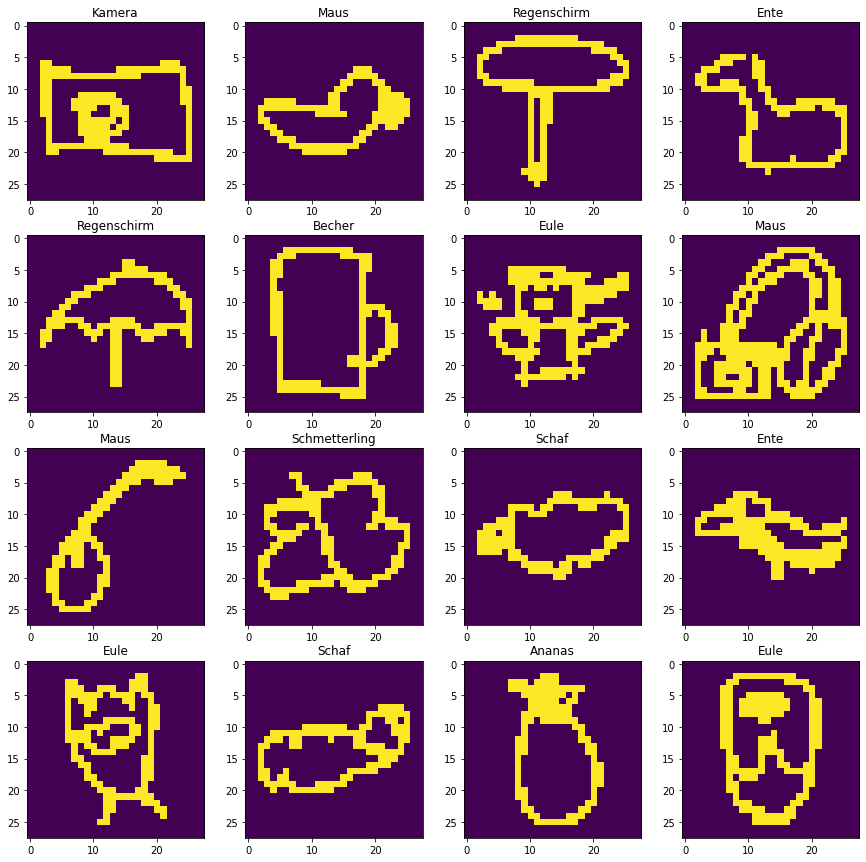

In [ ]:
dataloader_train = DataLoader(DS_train, batch_size=16, shuffle=True)

batch, label = next(iter(dataloader_train))

print(label)
plt.figure(figsize=[15,15])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(batch[i].squeeze().numpy())
    plt.title(DS_train.labelnames[int(label[i])])

## Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        out = x
        return out

## Training

In [ ]:
n_epochs = 3
batch_size = 128
lr = 1e-3
betas = (0.9, 0.999)

model = CNN().to(device)

dataloader_train = DataLoader(DS_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(DS_test, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(n_epochs):
    model.train()
    for i, (batch, label) in enumerate(dataloader_train):
        batch = batch.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()
        if i%500==0:
            print(i, loss.item(), (torch.sum(torch.argmax(output, dim=-1)==label)/len(batch)).item())
    
    model.eval()
    confusion_matrix = torch.zeros([13,13])
    acc = 0
    for batch, label in dataloader_test:
        batch = batch.to(device)
        label = label.to(device)
        output = model(batch)
        for i in range(len(label)):
            confusion_matrix[int(label[i]), int(torch.argmax(output[i]))] += 1
        acc += torch.sum(torch.argmax(output, dim=-1)==label).item()
    acc /= len(DS_test)
    print(f"Test-Accuracy epoch {epoch}: {acc}")
    plt.figure()
    plt.imshow(confusion_matrix.detach().cpu().numpy())
    plt.show()
        

## Selbst malen!

In [ ]:
make_prediction_canvas(canvas_size, "predict_func")

In [ ]:
plt.figure()
plt.barh(DS_train.labelnames, F.softmax(out, dim=-1).squeeze().detach().cpu().numpy())
plt.grid()
plt.show()
print(torch.max(F.softmax(out, dim=-1)).item())